In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%run -i sedfuncs.py

In [2]:
# Calculate wavenumber
T = 8.            # wave period (s)
wr = 2.*np.pi/T    # wave period (radians)
h = 5.             # water depth (m)

kh = qkhfs(wr, h)

print('kh: {:.3f} m, k: {:.3f}'.format(kh, kh/h))

kh: 0.592 m, k: 0.118


In [3]:
# Calculate wave-orbital velocity from Hs, T, h
Hs = 0.5
ubr = ub_func(T, kh/h, Hs, h)

print('ub: {:.2f} m/s'.format(ubr))

ub: 0.31 m/s


In [4]:
# Calculate wave-current bottoms shear stresses
# (this runs, but does not exactly match my Matlab output...still working)
ubr = 0.31
ucr = .5               # current speed at zr (m/s)
zr = 1.                # measurement elevation (m)
phiwc = 45.*np.pi/180. # angle between waves and currents (radians)
z0 = .005              # bottom roughness length scale (m)
kN = 30.*z0            # Nikuradse roughness (m)

ustrc, ustrr, ustrwm, dwc, fwc, zoa = \
    m94( ubr, wr, ucr, zr, phiwc, kN, iverbose=True )

print(ustrc, ustrr, ustrwm, dwc, fwc, zoa)

[1.] [2.63136173]
M94 nit= 3
i=0 fwc=[0.09923453] dwc=[0.15] u*c=[0.04806846] u*wm=[0.06905229] u*r=[0.06905229]  
i=1 fwc=[0.11676234] dwc=[0.15] u*c=[0.05234513] u*wm=[0.07490281] u*r=[0.08817183]  
i=2 fwc=[0.11690138] dwc=[0.15] u*c=[0.05237671] u*wm=[0.07494739] u*r=[0.08832832]  
[0.05237677] [0.08832864] [0.] [0.15] [0.11690167] [0.01996152]


,0,1
0,0.500000,0.237764
1,0.492404,0.220737
2,0.469846,0.197003
3,0.433013,0.167283
4,0.383022,0.132480
...,...,...
56,-0.469846,-0.197003
57,-0.433013,-0.167283
58,-0.383022,-0.132480
59,-0.321394,-0.093652


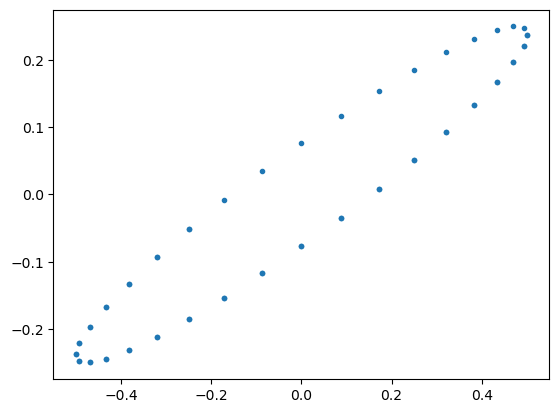

In [5]:
# read in test data for pcastats
df = pd.read_csv('D:/crs/matlab/m_cmg/cmglib/test_uv.csv', header=None)
u = df.iloc[:,0]
v = df.iloc[:,1]
plt.plot(u,v,'.')
df

In [9]:
mu = np.mean(u)
mv = np.mean(v)
print(mu, mv)
m = np.squeeze( np.dstack( (u,v) ) ).T
print(m)
C = np.cov( m )
print(C)
V, D = np.linalg.eig(C)
print('eigenvalues: \n', V)
print('eigenvectors: \n', D)

x1 = [.5*np.sqrt(V[0])*D[0,0],
     -.5*np.sqrt(V[0])*D[0,0]]

y1 = [.5*np.sqrt(V[0])*D[1,0],
     -.5*np.sqrt(V[0])*D[1,0]]

x2 = [.5*np.sqrt(V[1])*D[0,1],
     -.5*np.sqrt(V[1])*D[0,1]]

y2 = [.5*np.sqrt(V[1])*D[1,1],
     -.5*np.sqrt(V[1])*D[1,1]]
print(x1,y1)
print(x2,y2)

mspd, mdir = pcoord( mu, mv )
l1, az1 = pcoord( x1[0], y1[0] );
l2, az2 = pcoord( x2[0], y2[0] );
if(l1 < l2):
    ltemp = l1
    aztemp = az1
    l1 = l2
    az1 = az2
    l2 = ltemp
    az2 = aztemp

sd1 = 2*l1
sd2 = 2*l2
print('l1, az1', l1, az1)
print('l2, az2', l2, az2)

-0.03851932786885246 -0.028625426229508196
[[ 0.5       0.492404  0.469846  0.433013  0.383022  0.321394  0.25
   0.17101   0.086824  0.       -0.086824 -0.17101  -0.25     -0.321394
  -0.383022 -0.433013 -0.469846 -0.492404 -0.5      -0.492404 -0.469846
  -0.433013 -0.383022 -0.321394 -0.25     -0.17101  -0.086824 -0.
   0.086824  0.17101   0.25      0.321394  0.383022  0.433013  0.469846
   0.492404  0.5       0.492404  0.469846  0.433013  0.383022  0.321394
   0.25      0.17101   0.086824  0.       -0.086824 -0.17101  -0.25
  -0.321394 -0.383022 -0.433013 -0.469846 -0.492404 -0.5      -0.492404
  -0.469846 -0.433013 -0.383022 -0.321394 -0.25    ]
 [ 0.237764  0.220737  0.197003  0.167283  0.13248   0.093652  0.051978
   0.008725 -0.034793 -0.077254 -0.117368 -0.153915 -0.185786 -0.212012
  -0.231796 -0.244537 -0.249848 -0.247567 -0.237764 -0.220737 -0.197003
  -0.167283 -0.13248  -0.093652 -0.051978 -0.008725  0.034793  0.077254
   0.117368  0.153915  0.185786  0.212012  0.231796  0

In [7]:
def pcastats(u, v, s=0, ipost=0):
"""
% PCASTATS  Principal components of 2-d (e.g. current meter) data
%
% function [sd1 az1 sd2 az2]=pcastats(u,v,[[s],ipost])
%
% Input:
%    u and v are 1D column (vertical) vectors with x and y data
%    s is an optional length for the axes
%    ipost is an optional flag 0=no action, >1=plot input data
%
% Returns:
%    sd1, az1, sd2, az2
%
% Chris Sherwood, USGS
% Sept 26, 2005
% minor edits 30 Dec 2015
% conversion to Python June 2024
"""
mu = np.mean(u)
mv = np.mean(v)
# m is 2D array containing multiple variables and observations.
# Each row of m represents a variable, 
# and each column a single observation of all those variables
m = np.squeeze( np.dstack( (u,v) ) ).T
C = np.cov( m );
(V,D) = np.linalg.eig(C);

x1 = [.5*sqrt(D(1,1))*V(1,1);-.5*sqrt(D(1,1))*V(1,1)];
y1 = [.5*sqrt(D(1,1))*V(2,1);-.5*sqrt(D(1,1))*V(2,1)];
x2 = [.5*sqrt(D(2,2))*V(1,2);-.5*sqrt(D(2,2))*V(1,2)];
y2 = [.5*sqrt(D(2,2))*V(2,2);-.5*sqrt(D(2,2))*V(2,2)];
[mspd, mdir]=pcoord( mu, mv );
[ l1, az1 ] = pcoord( x1(1), y1(1) );
[ l2, az2 ] = pcoord( x2(1), y2(1) );
if(l1 < l2),
  ltemp = l1; aztemp = az1;
  l1 = l2;    az1 = az2;
  l2 = ltemp; az2 = aztemp;
end
sd1 = 2*l1;
sd2 = 2*l2;

if(ipost),
   hh1=plot(u(:),v(:),'ob');
   set(hh1,'markerfacecolor',[.9 .2 .2],'markeredgecolor',[.2 .2 .2],'markersize',4);
   hold on
   axis('square');
   axis([-s s -s s])
   ts = ['Speed= ',sprintf('%4.2f',mspd),'; Dir.= ',sprintf('%3.0f',mdir) ];
   hh2=text(-.8*s,.8*s,ts);
   set(hh2,'fontsize',14);
   for i=1:2
      eval(['[ leng(i), az(i) ] = pcoord( x' num2str(i) '(1), y' num2str(i) '(1) );']);
   end
   ts = ['Major axis: Mag.= ',sprintf('%4.2f',sd1),'; Az.= ',sprintf('%3.0f',az1) ];
   hh2=text(-.8*s,.6*s,ts);
   set(hh2,'fontsize',14);
   hh3=plot(x1,y1,'-r',x2,y2,'color',[1 .1 .1],'linewidth',2);
   hh4=plot([0; mu],[0; mv],'color',[.1 .1 1],'linewidth',2.5);
   xlabel('East ({\itu}) component (cm/s)','fontsize',14);
   ylabel('North ({\itv}) component (cm/s)','fontsize',14);
   grid
end


IndentationError: expected an indented block (2218612524.py, line 2)